In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
import sys 
sys.path.append('..')
from renderer import render

In [41]:
np.set_printoptions(suppress=True)
TIME_COLUMN_INDEX = 0
OPEN_COLUMN_INDEX = 1
CLOSE_COLUMN_INDEX = 4
VOLUME_COLUMN_INDEX = 5
EPISODE_SIZE = 720
LOOK_AHEAD = 3
FILTER_PADDING = 5
TRAIN_SPLIT = 0.85

In [42]:
def read_data(filename="../data/bitfinex-BTCUSD-1m.csv", date_columns="DateTime"):
    df = pd.read_csv(filename, parse_dates=[date_columns])
    df = df[~np.isnan(df['Close'])].set_index(pd.DatetimeIndex(df[date_columns]))
    df['Volume'] = ((df['Volume'] - df['Volume'].mean())/df['Volume'].std())
    return df

def normalize_episode(df_episode):
    df_episode_norm = df_episode.copy()
    df_episode_norm['Open']  = df_episode_norm['Open'] / df_episode.iloc[0]['Open']
    df_episode_norm['High']  = df_episode_norm['High'] / df_episode.iloc[0]['Open']
    df_episode_norm['Low']   = df_episode_norm['Low']  / df_episode.iloc[0]['Open']
    df_episode_norm['Close'] = df_episode_norm['Close']/df_episode.iloc[0]['Open']
    return df_episode_norm

def get_train_test_sets(df, train_split):
    state_len = df.shape[0]
    train_end_index = int(train_split * state_len)
    train_state = df[0:train_end_index]
    test_state = df[train_end_index:]
    print("Train state: ", train_state.shape, "test state: ", test_state.shape, "total:", state_len)
    return train_state, test_state

def get_state_episodes_count(state, episode_size, look_ahead):
    return state.shape[0] - episode_size - look_ahead

def get_features_number(df):
    return df.shape[1] - 1

def get_y_label_episode(episode_data, look_ahead, filter_padding=FILTER_PADDING, smooth=True, normalize=True):
    regular_close = episode_data['Close']
    shifted_close = episode_data.shift(-look_ahead)['Close']
    diff = (shifted_close - regular_close).dropna()
    if normalize:
        diff = diff / diff.std()
    if smooth:
        diff = savgol_filter(diff, filter_padding * 2 + 1, 3)
    y_category = ((np.sign(diff) + 1) / 2).astype(int)
    return diff[:-filter_padding], y_category[:-filter_padding]

def get_y_label_final(episode_data, look_ahead, filter_padding=FILTER_PADDING, smooth=True, normalize=True):
    filter_window = filter_padding * 2 + 1
    regular_close = episode_data['Close']
    shifted_close = episode_data.shift(-look_ahead)['Close']
    diff = (shifted_close - regular_close).dropna()
    if normalize:
        diff = diff / diff.std()
    # trim
    diff = diff[-filter_window:]
    if smooth:
        diff = savgol_filter(diff, filter_window, 3)
    y_category = ((np.sign(diff) + 1) / 2).astype(int)
    return diff[filter_padding], y_category[filter_padding]

def get_episode_data(state, start_index, episode_size, look_ahead, filter_padding=FILTER_PADDING, final_y_label=False):
    episode_state = state[start_index : start_index + episode_size].copy()
    X_episode = np.array(normalize_episode(episode_state))[:-look_ahead-filter_padding,:]
    Y_diff, Y_category = get_y_label_final(episode_state, look_ahead) if final_y_label else get_y_label_episode(episode_state, look_ahead)
    return X_episode, np.array(Y_diff), np.array(Y_category)

In [43]:
df = read_data()
train_state, test_state = get_train_test_sets(df, TRAIN_SPLIT)
X_episode, Y_diff, Y_category = get_episode_data(train_state, start_index=675000, episode_size=EPISODE_SIZE, look_ahead=LOOK_AHEAD)
print(X_episode[-5:], Y_diff[-5], X_episode.shape, Y_diff.shape)

Train state:  (686800, 6) test state:  (121200, 6) total: 808000
[[Timestamp('2018-01-10 01:18:00') 0.9828075195650914 0.9845329541148897
  0.981220119779277 0.9845329541148897 0.2978453163279346]
 [Timestamp('2018-01-10 01:19:00') 0.9823243978911479 0.9854301800807848
  0.9823243978911479 0.9853611626987928 0.012886122211452937]
 [Timestamp('2018-01-10 01:20:00') 0.9854301800807848 0.9878457884505024
  0.9835667107670026 0.98418786720493 0.5450270382423476]
 [Timestamp('2018-01-10 01:21:00') 0.9840498324409462 0.9866724929566395
  0.9840498324409462 0.9854991974627767 0.03951447221720294]
 [Timestamp('2018-01-10 01:22:00') 0.9854991974627767 0.9859823191367202
  0.9854301800807848 0.9858442843727364 -0.2218674707011879]] 0.25496810548406446 (712, 6) (712,)


In [44]:
def render_X(X_set, start=0, end=500):
    trade_values = X_set[start:end].copy().T
    print(trade_values.T.shape)
    render(trade_values.T, title="X", scale=1, base_rect_coef=0.01)
    
def render_y(y, start=0, end=500):
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(y[start:end])
    plt.show()

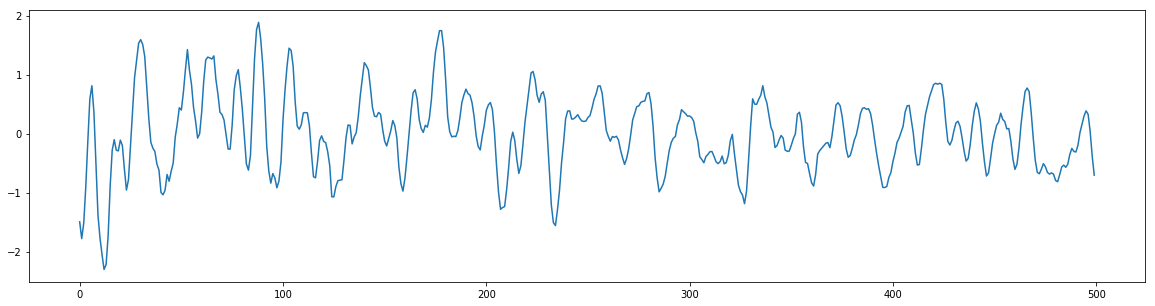

In [45]:
render_y(Y_diff, start=0, end=500)

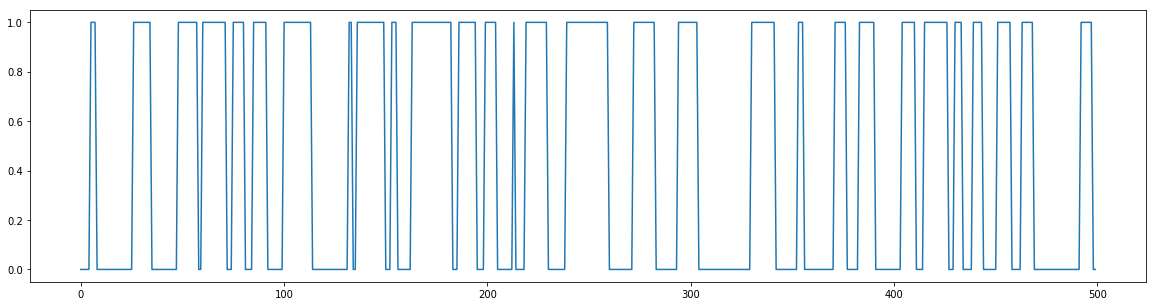

In [46]:
render_y(Y_category, start=0, end=500)

(100, 6)


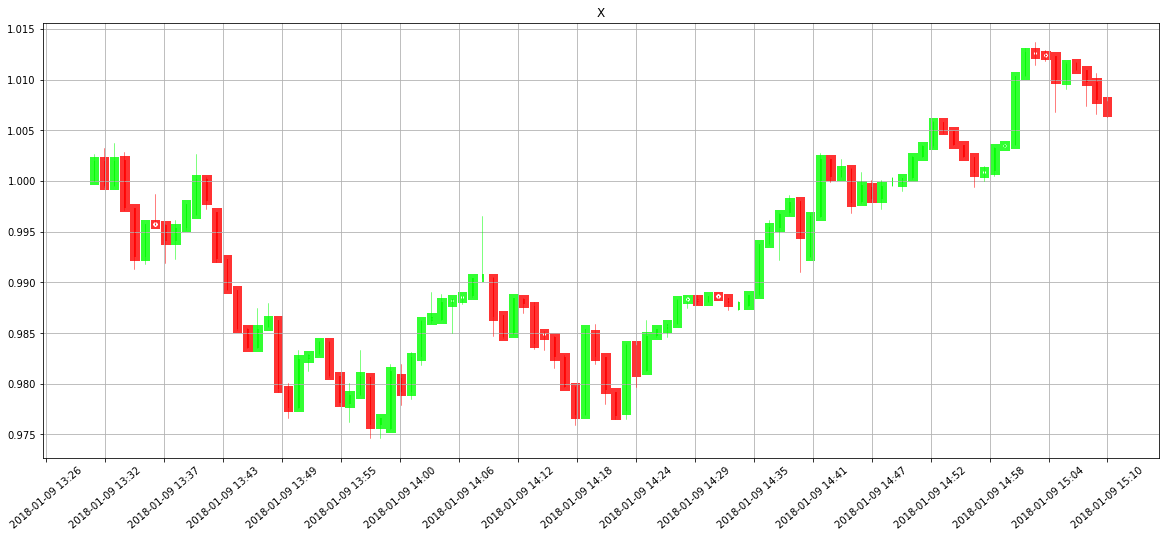

In [39]:
render_X(X_episode, start=0, end=100)

In [24]:
# train / test
def create_dataset(state, episode_size, look_ahead, filter_padding=FILTER_PADDING, step=1):
    episodes_count = get_state_episodes_count(state, episode_size, look_ahead)
    length = episodes_count // step
    print("Episodes:", episodes_count, "Length:", length)
    features_number = get_features_number(state)
    
    X_set = np.zeros((length, features_number, episode_size-look_ahead-filter_padding))
    Y_diff = np.zeros((length, 1))
    Y_category = np.zeros((length, 1))
    
    for i in range(length):
        X, yd, yc = get_episode_data(state, start_index=i*step, episode_size=episode_size, look_ahead=look_ahead, final_y_label=True)
        X_set[i, :, :] = X.T[1:,:]
        Y_diff[i], Y_category[i] = yd, yc
        if i % 5000 == 0:
            print("Processed: ", i)
    return X_set, Y_diff, Y_category

In [25]:
X_set_train, Y_diff_train, Y_category_train = create_dataset(train_state, EPISODE_SIZE, LOOK_AHEAD, step=20)

Episodes: 686075 Length: 34303
Processed:  0
Processed:  5000
Processed:  10000
Processed:  15000
Processed:  20000
Processed:  25000
Processed:  30000


(701, 5)


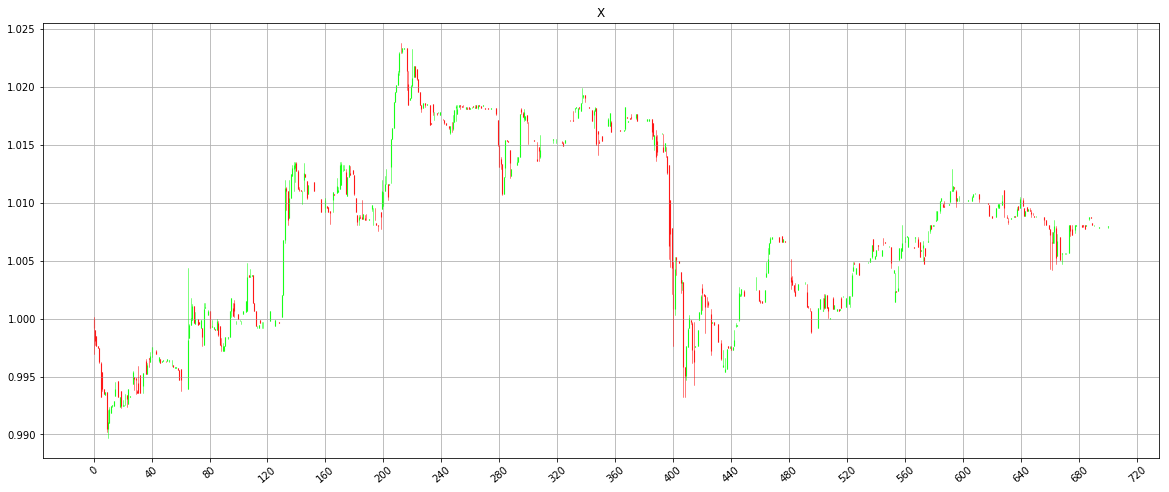

In [26]:
render_X(X_set_train[0].T, start=0, end=701)

In [28]:
# Let's test y_data
Y_diff_train[1][0], Y_category_train[1][0]
# Get raw data
start_index, episode_size, look_ahead = 5, EPISODE_SIZE, LOOK_AHEAD
episode_state = train_state[start_index : start_index + episode_size].copy()
Y_diff_final, Y_category_final = get_y_label_final(episode_state, look_ahead)
Y_diff_episode, Y_category_episode = get_y_label_episode(episode_state, look_ahead)
#
#assert(Y_diff_train[1][0] == Y_diff_final == Y_diff_episode[-1])
#assert(Y_category_train[1][0] == Y_category_final == Y_category_episode[-1])

In [30]:
X_set_test, Y_diff_test, Y_category_test = create_dataset(test_state, EPISODE_SIZE, LOOK_AHEAD, step=20)

Episodes: 120475 Length: 6023
Processed:  0
Processed:  5000


In [31]:
FOLDER = os.path.join(os.getcwd(), '..', 'prepared_data/')
np.save(FOLDER + 'X_train5.npy', X_set_train)
np.save(FOLDER + 'y_train_diff5.npy', Y_diff_train)
np.save(FOLDER + 'y_train5.npy', Y_category_train)
np.save(FOLDER + 'X_test5.npy', X_set_test)
np.save(FOLDER + 'y_test_diff5.npy', Y_diff_test)
np.save(FOLDER + 'y_test5.npy', Y_category_test)